# Import libraries

In [22]:
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, multilabel_confusion_matrix, classification_report
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.torch_core import tensor
from fastai.vision.all import vision_learner, accuracy_multi, F1ScoreMulti, RocAucMulti


# Data Preprocessing

## Data Download

In [ ]:
# Set the download path
download_path = 'download_path'

# Create download directory if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

# List of file URLs
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

# Function to download a file
def download_file(url, download_dir, idx):
    fn = os.path.join(download_dir, f'images_{idx+1:02d}.tar.gz')
    print(f'Downloading {fn}...')
    urllib.request.urlretrieve(url, fn)  # Download the file
    print(f'{fn} download complete.')

# Create and start download threads
threads = []
for idx, link in enumerate(links):
    thread = threading.Thread(target=download_file, args=(link, download_path, idx))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()

print("All downloads complete. Files are saved in", download_path)

In [ ]:
# Set the extraction directory
extract_dir = 'extract_dir'

# Loop through all downloaded files and extract
for idx in range(1, len(links) + 1):
    tar_path = os.path.join(download_path, f'images_{idx:02d}.tar.gz')

    # Extract the tar.gz file
    print(f'Extracting {tar_path} to {extract_dir}...')
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

    # Delete the tar.gz file after extraction
    os.remove(tar_path)
    print(f'Deleted {tar_path} after extraction.')

# Print completion message
print("Extraction complete.")

## Train & Test dataset split

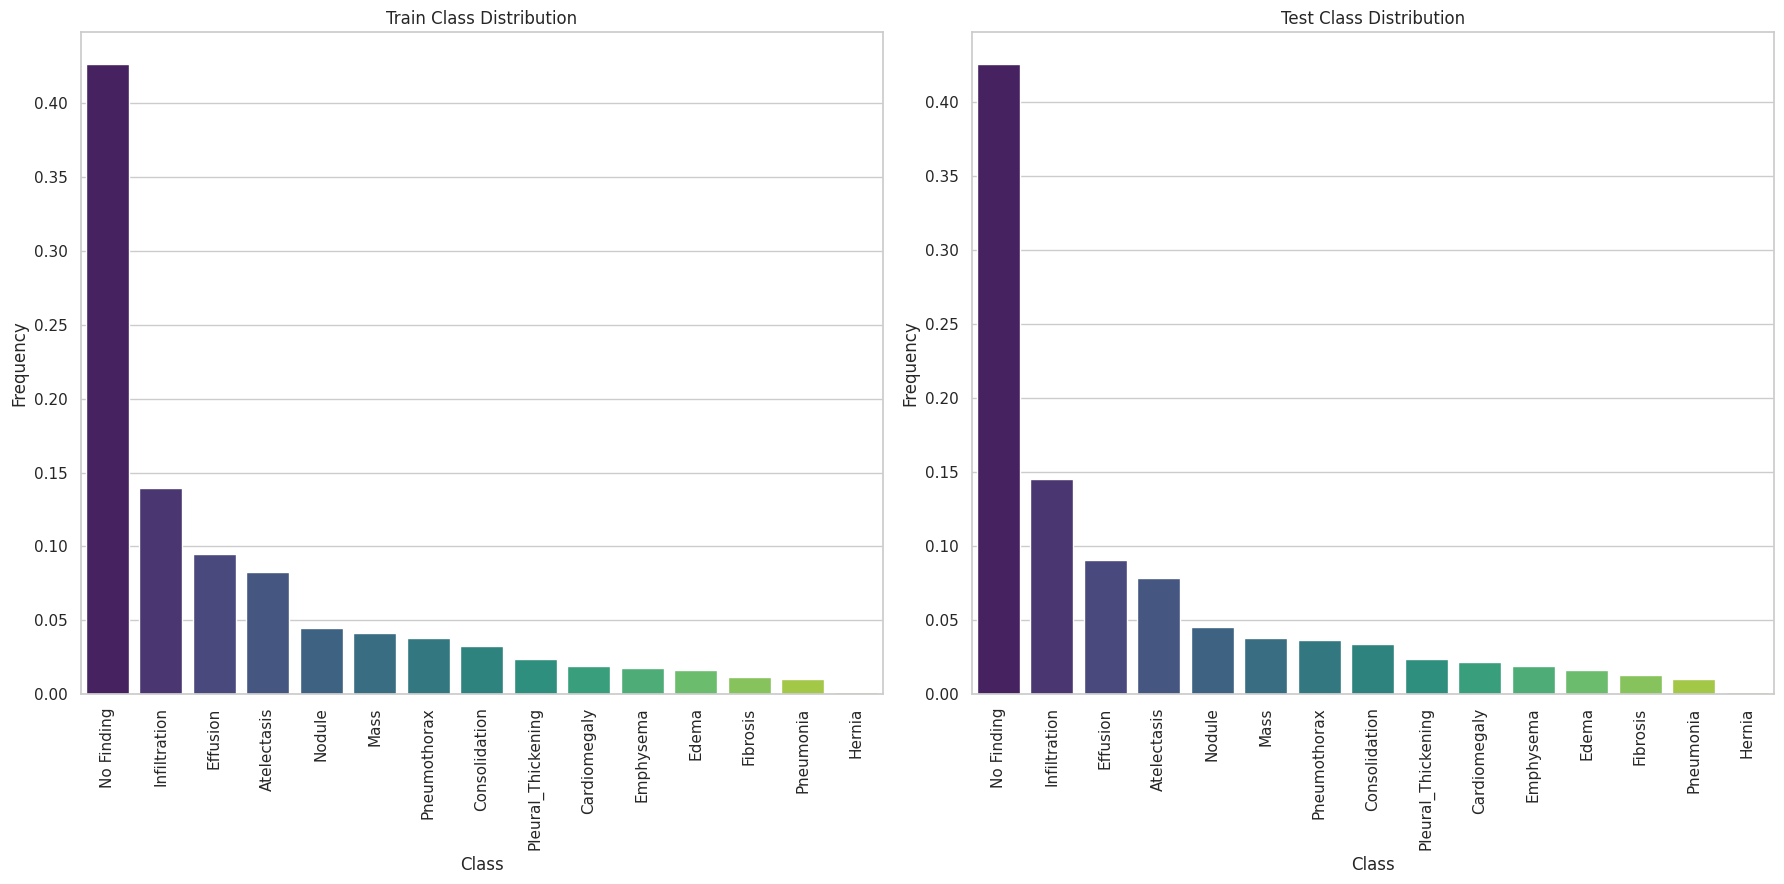

In [23]:
# Load the CSV file into a DataFrame
csv_file_path = './Data_Entry_2017_v2020.csv'
df = pd.read_csv(csv_file_path)

# Split the Data into train and test dataset based on 'Patient ID'
group_split = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_indices, test_indices = next(group_split.split(df, groups=df['Patient ID']))
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]

# Count the frequency of each class in the train and test sets
train_class_counts = train_df['Finding Labels'].str.split('|', expand=True).stack().value_counts()
test_class_counts = test_df['Finding Labels'].str.split('|', expand=True).stack().value_counts()

# Create a plot for class distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Plot for the train set
sns.barplot(x=train_class_counts.index, y=train_class_counts.values/train_class_counts.sum(), 
            hue=train_class_counts.index, palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Train Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

# Plot for the test set
sns.barplot(x=test_class_counts.index, y=test_class_counts.values/test_class_counts.sum(), 
            hue=test_class_counts.index, palette='viridis', ax=axes[1], legend=False)
axes[1].set_title('Test Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [24]:
# Define binary class categories
binary_classes = ['Major', 'Minor']

# Define major (6 classes) and minor (8 classes) categories
major_classes = ['Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Mass', 'Pneumothorax']
minor_classes = ['Consolidation', 'Pleural_Thickening', 'Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Pneumonia', 'Hernia']

# Define all classes
total_classes = major_classes + minor_classes

# Create copies of the train DataFrame for binary, major, minor classifications
binary_train_df = train_df.copy()
major_train_df = train_df.copy()
minor_train_df = train_df.copy()

# Assign binary labels based on the presence of major/minor classes in train data
binary_train_df.loc[:, 'Binary Labels'] = binary_train_df['Finding Labels'].apply(
    lambda x: (
        'None' if x == 'No Finding' else
        'Both' if any(label in major_classes for label in x.split('|')) and any(label in minor_classes for label in x.split('|')) else
        'Major' if any(label in major_classes for label in x.split('|')) else
        'Minor'
    )
)

# Assign binary labels for the test data
test_df = test_df.copy()
test_df.loc[:, 'Binary Labels'] = test_df['Finding Labels'].apply(
    lambda x: (
        'None' if x == 'No Finding' else
        'Both' if any(label in major_classes for label in x.split('|')) and any(label in minor_classes for label in x.split('|')) else
        'Major' if any(label in major_classes for label in x.split('|')) else
        'Minor'
    )
)

# Filter the train data to include only images with major classes
major_train_df.loc[:, 'Finding Labels'] = major_train_df['Finding Labels'].apply(
    lambda x: '|'.join(sorted([label for label in x.split('|') if label in major_classes]))
)
major_train_df = major_train_df[major_train_df['Finding Labels'] != '']

# Filter the train data to include only images with minor classes
minor_train_df.loc[:, 'Finding Labels'] = minor_train_df['Finding Labels'].apply(
    lambda x: '|'.join(sorted([label for label in x.split('|') if label in minor_classes]))
)
minor_train_df = minor_train_df[minor_train_df['Finding Labels'] != '']

# Print dataset sizes for each category
print(f'binary train data: {binary_train_df.shape[0]}')
print(f'major train data: {major_train_df.shape[0]}')
print(f'minor train data: {minor_train_df.shape[0]}')
print(f'test data: {test_df.shape[0]}')

binary train data: 89826
major train data: 36028
minor train data: 13480
test data: 22294


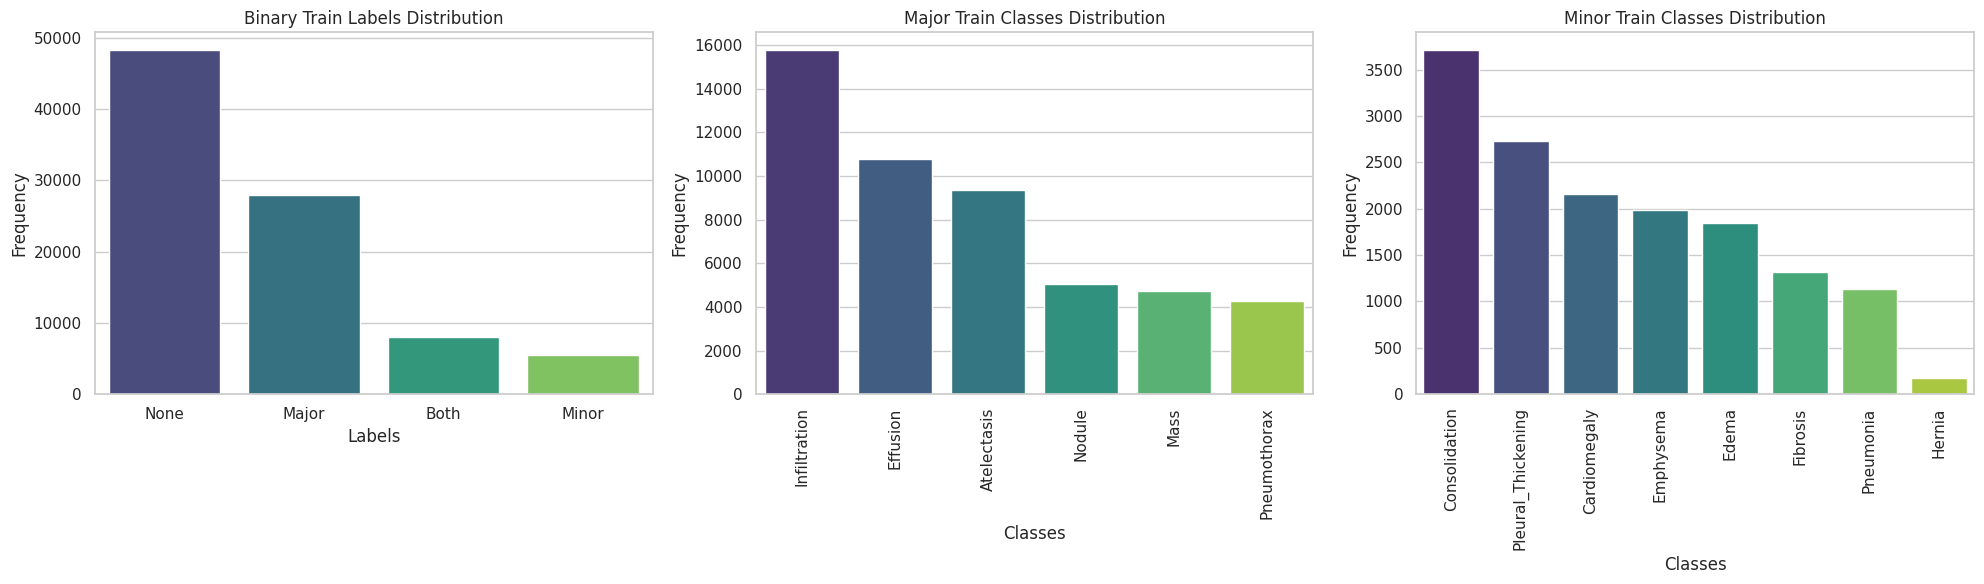

In [27]:
# Set Seaborn style for the plots
sns.set(style="whitegrid")

# Function to plot the frequency of binary labels
def plot_binary_distribution(df, title, ax):
    # Count the frequency of each binary label
    label_counts = df['Binary Labels'].value_counts()
    # Create a bar plot for binary label frequencies
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, dodge=False, ax=ax)
    # Set plot title and axis labels
    ax.set_title(title)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=0)  # Keep x-axis labels horizontal

# Function to plot the frequency of individual classes
def plot_class_distribution(df, classes, title, ax):
    # Count the frequency of each class in the dataset
    class_counts = {cls: df['Finding Labels'].str.contains(cls).sum() for cls in classes}
    # Create a bar plot for class frequencies
    sns.barplot(
        x=list(class_counts.keys()), 
        y=list(class_counts.values()), 
        palette="viridis", 
        hue=list(class_counts.keys()), 
        dodge=False, 
        ax=ax
    )
    # Set plot title and axis labels
    ax.set_title(title)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Create a figure with three subplots to visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

# Plot the binary label frequency for the training dataset
plot_binary_distribution(binary_train_df, 'Binary Train Labels Distribution', axes[0])

# Plot the class frequency for major classes in the training dataset
plot_class_distribution(major_train_df, major_classes, 'Major Train Classes Distribution', axes[1])

# Plot the class frequency for minor classes in the training dataset
plot_class_distribution(minor_train_df, minor_classes, 'Minor Train Classes Distribution', axes[2])

# Adjust layout to avoid overlapping of subplots
plt.tight_layout()
plt.show()


# Training

In [28]:
SEED = 64  # Set random seed for reproducibility

# Item-level transformations
item_transforms = [
    Resize((224, 224)),  # Resize images to 224x224
]

# Batch-level augmentations
batch_transforms = [
    Flip(),  # Random horizontal flip
    Rotate(),  # Random rotation
    Normalize.from_stats(*imagenet_stats),  # Normalize with ImageNet stats
]

# Get image file path from row
def get_x(row):
    base_dir = '/data2/UROP/kimjk/BDL/DATA/images'  # Base directory for images
    image_idx = row['Image Index']  # Image index from the CSV
    return f"{base_dir}/{image_idx}"  # Return full image path

In [29]:
class BCEWithFocalLoss(nn.Module):
    def __init__(self, reduction='mean', alpha=0.5, gamma_neg=4, gamma_pos=1):
        super(BCEWithFocalLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction)
        self.alpha = alpha
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos

    def forward(self, logits, targets):
        # Compute BCE loss
        bce_loss = self.bce_loss(logits, targets)

        # Compute probabilities and focal weight
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
        focal_weight = torch.mean((1 - p_t).pow(gamma))

        # Combine BCE loss with focal weight
        total_loss = self.alpha * focal_weight * bce_loss

        return total_loss

## Binary Classifier Training

In [30]:
def get_binary_labels(diseases):
    # Return binary labels based on disease classification
    if diseases == 'Both':
        return tensor([1, 1])  # Both major and minor diseases
    elif diseases == 'Major':
        return tensor([1, 0])  # Only major diseases
    elif diseases == 'Minor':
        return tensor([0, 1])  # Only minor diseases
    elif diseases == 'None':
        return tensor([0, 0])  # No diseases
    else:
        return None  # Invalid input

In [31]:
def get_binary_y(row):
    # Get binary labels for each row based on 'Binary Labels' column
    diseases = row['Binary Labels']
    label = get_binary_labels(diseases)  # Convert label to binary format
    return label

# Create a DataBlock for processing images and labels
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=binary_classes)),  # Define input and output blocks
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),  # Split data into train and validation sets
    get_x=get_x,  # Function to get image path
    get_y=get_binary_y,  # Function to get labels
    item_tfms=item_transforms,  # Item-level transformations (resizing)
    batch_tfms=batch_transforms  # Batch-level transformations (augmentation)
)

# Create dataloaders for training and validation sets
dls = dblock.dataloaders(binary_train_df, bs=16, num_workers=os.cpu_count(), pin_memory=True)

# Define callback functions for saving model, early stopping, and showing graphs
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True, every_epoch=True),
    # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5), #Early stopping is not used to monitor the training progress."
    ShowGraphCallback()
]

# Initialize ResNet50 model pre-trained on ImageNet
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer to match the number of binary classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(binary_classes))

# Create a Learner object for training
learn = Learner(
    dls,  # Dataloaders
    resnet50,  # Model
    loss_func=nn.BCEWithLogitsLoss(),  # Binary Cross-Entropy loss
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],  # Evaluation metrics
    cbs=cbs,  # Callbacks
    wd=0.001  # Weight decay for regularization
)


Initial learning rate: 0.0014454397605732083


/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.637510,0.616318,0.662155,0.651199,0.716647,01:48
1,0.618775,0.609892,0.670117,0.659999,0.725607,01:46


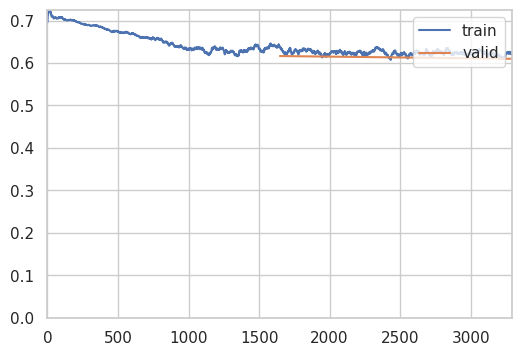

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.601884,0.605399,0.671444,0.650729,0.732979,01:46
1,0.596064,0.600836,0.680069,0.669308,0.735563,01:47
2,0.603773,0.599043,0.674761,0.680556,0.737551,01:47
3,0.591944,0.601952,0.674363,0.647591,0.737607,01:47
4,0.597350,0.598104,0.680467,0.663454,0.740296,01:47
5,0.586366,0.603752,0.676752,0.665812,0.734391,01:47
6,0.598117,0.599159,0.680998,0.684966,0.738664,01:47
7,0.587438,0.602493,0.670117,0.628356,0.740443,01:47
8,0.589914,0.599909,0.678211,0.665068,0.740000,01:47
9,0.593588,0.596991,0.677282,0.664686,0.741646,01:47


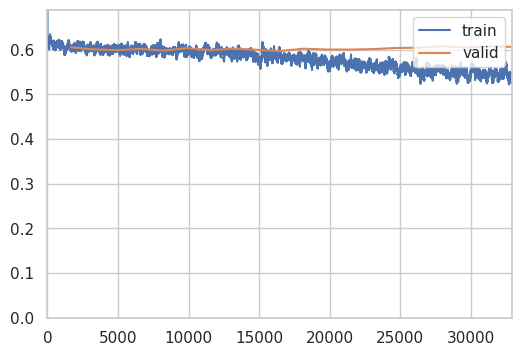

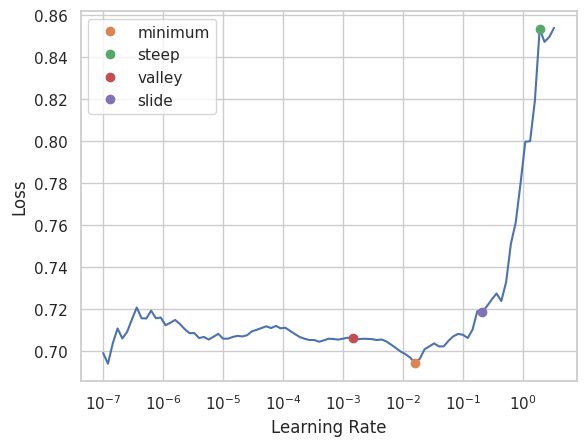

In [107]:
# Find the learning rate using the learning rate finder
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))  # Suggest learning rates based on different methods
print('Initial learning rate:', lrs.valley)  # Print the learning rate at the "valley" of the curve

# Fine-tune the model: 
# Freeze the first few layers for 2 epochs, then unfreeze and train for 20 epochs with the suggested learning rate
learn.fine_tune(freeze_epochs=2, epochs=20, base_lr=lrs.valley)

In [108]:
# Define the path to the best model checkpoint
best_path='models/model_11.pth'
best_path = Path(best_path)  # Convert the path to a Path object

# Load the best model using the model's filename
learn.load(best_path.stem)

# Export the trained model to a file
learn.export('binary.pkl')

/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

## Major Classifier Training

In [32]:
# Get multi labels for major classes
def get_major_y(row):
    label = [0] * len(major_classes)  # Initialize label
    for label_name in row['Finding Labels'].split('|'):  # Iterate through diseases
        if label_name in major_classes:  
            label[major_classes.index(label_name)] = 1 # If it's a major class set label to 1
    return label

# Create a DataBlock for processing images and labels
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=binary_classes)),  # Define input and output blocks
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),  # Split data into train and validation sets
    get_x=get_x,  # Function to get image path
    get_y=get_major_y,  # Function to get labels
    item_tfms=item_transforms,  # Item-level transformations (resizing)
    batch_tfms=batch_transforms  # Batch-level transformations (augmentation)
)

# Create dataloaders for training and validation sets
dls = dblock.dataloaders(major_train_df, bs=16, num_workers=os.cpu_count(), pin_memory=True)

# Define callback functions for saving model, early stopping, and showing graphs
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True, every_epoch=True),
    # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5), #Early stopping is not used to monitor the training progress."
    ShowGraphCallback()
]

# Initialize ResNet18 model pre-trained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer to match the number of major classes
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, len(major_classes))

# Create a Learner object for training
learn = Learner(
    dls, # Dataloaders
    resnet18, # Model
    loss_func=BCEWithFocalLoss(), # Focal loss
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()], # Evaluation metrics
    cbs=cbs, # Callbacks
    wd=0.001 # Weight decay for regularization
)

Initial learning rate: 0.019054606556892395


/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.015625,0.016512,0.859917,0.129143,0.698416,00:58
1,0.015175,0.015452,0.878805,0.136424,0.712655,00:59


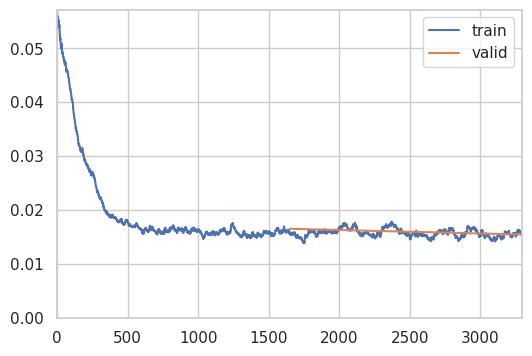

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.014142,0.014630,0.881458,0.148481,0.738032,00:59
1,0.014046,0.014580,0.878494,0.179630,0.744334,00:59
2,0.014661,0.014482,0.879821,0.182399,0.743088,00:59
3,0.013598,0.014590,0.879158,0.167174,0.744891,00:59
4,0.015069,0.014708,0.874779,0.190372,0.746495,00:59
5,0.015158,0.014584,0.881812,0.172647,0.746948,00:59
6,0.013567,0.014566,0.881767,0.139712,0.746680,00:59
7,0.015121,0.014791,0.873585,0.214446,0.745808,00:59
8,0.015721,0.014751,0.870179,0.221877,0.748927,00:59
9,0.014695,0.014477,0.880175,0.191398,0.747907,00:59


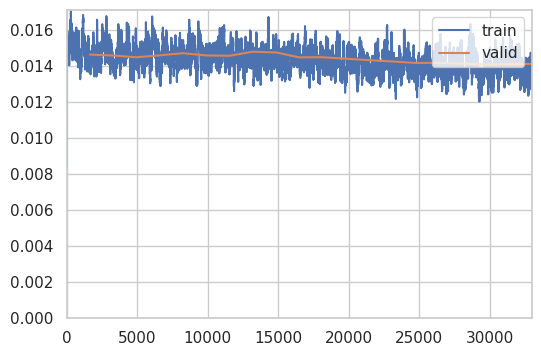

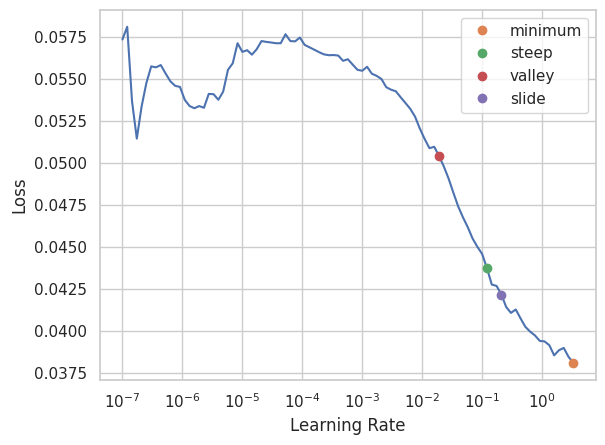

In [112]:
# Find the learning rate using the learning rate finder
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))  # Suggest learning rates based on different methods
print('Initial learning rate:', lrs.valley)  # Print the learning rate at the "valley" of the curve

# Fine-tune the model: 
# Freeze the first few layers for 2 epochs, then unfreeze and train for 20 epochs with the suggested learning rate
learn.fine_tune(freeze_epochs=2, epochs=20, base_lr=lrs.valley)

In [113]:
# Define the path to the best model checkpoint
best_path='models/model_19.pth'
best_path = Path(best_path) # Convert the path to a Path object

# Load the best model using the model's filename
learn.load(best_path.stem)

# Export the trained model to a file
learn.export('major.pkl')

/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

## Minor Classifier Training

In [33]:
# Get multi labels for minor classes
def get_minor_y(row):
    label = [0] * len(minor_classes)  # Initialize label
    for label_name in row['Finding Labels'].split('|'):  # Iterate through diseases
        if label_name in minor_classes:  
            label[minor_classes.index(label_name)] = 1 # If it's a minor class set label to 1
    return label

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=binary_classes)),  # Define input and output blocks
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),  # Split data into train and validation sets
    get_x=get_x,  # Function to get image path
    get_y=get_minor_y,  # Function to get labels
    item_tfms=item_transforms,  # Item-level transformations (resizing)
    batch_tfms=batch_transforms  # Batch-level transformations (augmentation)
)

# Create dataloaders for training and validation sets
dls = dblock.dataloaders(minor_train_df, bs=16, num_workers=os.cpu_count(), pin_memory=True)

# Define callback functions for saving model, early stopping, and showing graphs
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True, every_epoch=True),
    # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5), #Early stopping is not used to monitor the training progress."
    ShowGraphCallback()
]

# Initialize MobileNet model pre-trained on ImageNet
mobilenet = mobilenet_v2(weights='IMAGENET1K_V1')

# Modify the final fully connected layer to match the number of minor classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, len(minor_classes))

# Create a Learner object for training
learn = Learner(
    dls, # Dataloaders
    mobilenet, # Model
    loss_func=nn.BCEWithLogitsLoss(), # Binary Cross-Entropy loss
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()], # Evaluation metrics
    cbs=cbs, # Callbacks
    wd=0.001 # Weight decay for regularization
)

Initial learning rate: 0.001737800776027143


/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.334432,0.334923,0.867062,0.191763,0.743136,00:44
1,0.341769,0.355813,0.857122,0.135171,0.746953,00:44


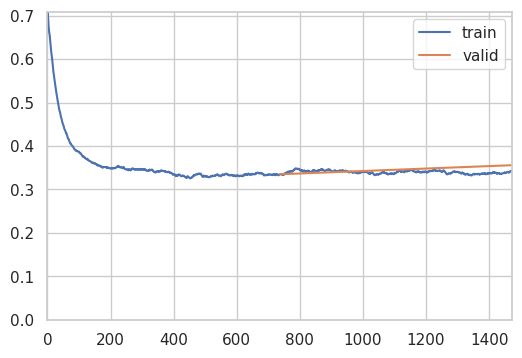

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.301394,0.300720,0.873220,0.233949,0.789538,00:45
1,0.291552,0.294189,0.879154,0.305184,0.798704,00:44
2,0.289353,0.294433,0.878783,0.283375,0.795785,00:44
3,0.297384,0.304610,0.875519,0.263664,0.793590,00:44
4,0.296497,0.295912,0.877522,0.290398,0.797679,00:45
5,0.284341,0.296492,0.878561,0.302446,0.797808,00:42
6,0.289448,0.403285,0.846736,0.209648,0.765919,00:45
7,0.290913,0.297411,0.878338,0.310484,0.804491,00:45
8,0.282205,0.295842,0.879080,0.295363,0.799389,00:45
9,0.287648,0.298450,0.878190,0.310214,0.813267,00:45


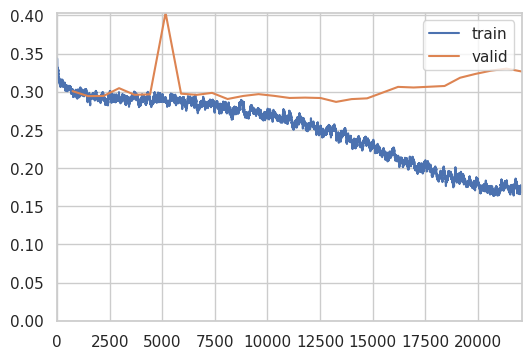

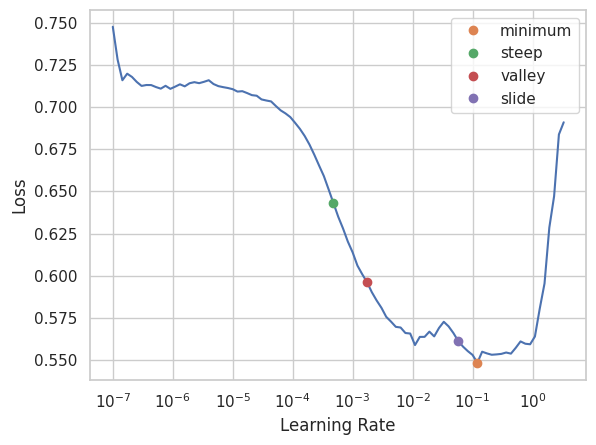

In [15]:
# Find the learning rate using the learning rate finder
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))  # Suggest learning rates based on different methods
print('Initial learning rate:', lrs.valley)  # Print the learning rate at the "valley" of the curve

# Fine-tune the model: 
# Freeze the first few layers for 2 epochs, then unfreeze and train for 30 epochs with the suggested learning rate
learn.fine_tune(freeze_epochs=2, epochs=30, base_lr=lrs.valley)

In [16]:
# Define the path to the best model checkpoint
best_path='models/model_24.pth'
best_path = Path(best_path) # Convert the path to a Path object

# Load the best model using the model's filename
learn.load(best_path.stem)

# Export the trained model to a file
learn.export('minor.pkl')

/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device,

# Inference

In [34]:
# Inference function to make predictions on test data
def inference(model_path, test_df, get_y, class_names):

    # Load the trained model
    learn = load_learner(model_path)
    
    # Create DataBlock for test dataset
    test_dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=class_names)),  # Define data blocks
        splitter=RandomSplitter(valid_pct=0, seed=SEED),  # No validation split
        get_x=get_x,  # Function to get the image path
        get_y=get_y,  # Function to get the labels
        item_tfms=[Resize((224, 224))],  # Resize images
        batch_tfms=[Normalize.from_stats(*imagenet_stats)]  # Normalize using ImageNet statistics
    )
    
    # Create DataLoader for the test dataset
    test_dl = test_dblock.dataloaders(test_df, bs=1, num_workers=os.cpu_count(), pin_memory=True)

    # Get predictions and true labels
    preds, y_test = learn.get_preds(dl=test_dl)
    
    # Apply threshold to get binary predictions (0 or 1)
    preds_thresh = (preds > 0.5).int() 
    
    predictions = []
    for i in range(preds_thresh.shape[0]):
        # Collect the predicted labels for each image
        pred_labels = [class_names[j] for j in range(preds_thresh.shape[1]) if preds_thresh[i, j] == 1]
        predictions.append('|'.join(pred_labels))  # Join labels with '|' separator
    
    return predictions  # Return the final predictions

## Binary Inference

In [35]:
# Perform inference and get binary predictions for the test data using binary classifier
binary_result = inference('binary.pkl', test_df, get_binary_y, binary_classes)

# Add the binary predictions to the test dataframe
test_df['Binary Prediction'] = binary_result

# Create a DataFrame for the 'Major' class predictions
major_df = test_df[test_df['Binary Prediction'].str.contains('Major', na=False)].copy()

# Create a DataFrame for the 'Minor' class predictions
minor_df = test_df[test_df['Binary Prediction'].str.contains('Minor', na=False)].copy()

# Assign 'No Finding' to rows with 'None' binary predictions
test_df.loc[test_df['Binary Prediction'].isna() | (test_df['Binary Prediction'] == ''), 'Prediction'] = 'No Finding'

## Major Inference

In [39]:
# Perform inference and get major disease predictions for the major data using major diseases classifier
major_result = inference('major_focal.pkl', major_df, get_y, major_classes)

# Add the major disease predictions to the major dataframe
major_df['Prediction'] = major_result

In [38]:
def get_y(row):
    label = [0] * len(major_classes)  # Initialize label
    for label_name in row['Finding Labels'].split('|'):  # Iterate through diseases
        if label_name in major_classes:  
            label[major_classes.index(label_name)] = 1 # If it's a major class set label to 1
    return label

In [40]:
# Add the major disease inference results to test_df
for idx, row in major_df.iterrows():

    # Get the image index and predicted class for the current row
    image_index = row['Image Index']
    new_prediction = row['Prediction']

    # Get the current prediction for the image from test_df
    current_prediction = test_df.loc[test_df['Image Index'] == image_index, 'Prediction'].iloc[0]

    # If no prediction exists, assign the new prediction
    if pd.isna(current_prediction) or current_prediction == '':
        test_df.loc[test_df['Image Index'] == image_index, 'Prediction'] = new_prediction
    else:
        # If a prediction already exists, append the new prediction to the current prediction
        test_df.loc[test_df['Image Index'] == image_index, 'Prediction'] = f"{current_prediction}|{new_prediction}"

## Minor Inference

In [41]:
# Perform inference and get minor disease predictions for the minor data using minor diseases classifier
minor_result = inference('minor.pkl', minor_df, get_minor_y, minor_classes)

# Add the major disease predictions to the major dataframe
minor_df['Prediction'] = minor_result

In [42]:
# Add the minor disease inference results to test_df
for idx, row in minor_df.iterrows():

    # Get the image index and predicted class for the current row
    image_index = row['Image Index']
    new_prediction = row['Prediction']

    # Get the current prediction for the image from test_df
    current_prediction = test_df.loc[test_df['Image Index'] == image_index, 'Prediction'].iloc[0]

    # If no prediction exists, assign the new prediction
    if pd.isna(current_prediction) or current_prediction == '':
        test_df.loc[test_df['Image Index'] == image_index, 'Prediction'] = new_prediction
    else:
        # If a prediction already exists, append the new prediction to the current prediction
        test_df.loc[test_df['Image Index'] == image_index, 'Prediction'] = f"{current_prediction}|{new_prediction}"

# Evaluation

In [43]:
# Initialize ground truth and prediction arrays
y_test = np.zeros((len(test_df), len(total_classes)))
y_pred = np.zeros((len(test_df), len(total_classes)))

# Populate y_test with true labels
for idx, row in test_df.iterrows():
    finding_labels = row['Finding Labels'].split('|')
    for label in finding_labels:
        if label in total_classes:
            y_test[test_df.index.get_loc(idx), total_classes.index(label)] = 1

# Populate y_pred with predicted labels
for idx, row in test_df.iterrows():
    finding_labels = row['Prediction'].split('|')
    for label in finding_labels:
        if label in total_classes:
            y_pred[test_df.index.get_loc(idx), total_classes.index(label)] = 1


In [44]:
# Calculate subset accuracy (exact match ratio)
subset_accuracy = accuracy_score(y_test, y_pred)

# Calculate precision using macro averaging
precision = precision_score(y_test, y_pred, average='macro')

# Calculate recall using macro averaging
recall = recall_score(y_test, y_pred, average='macro')

# Calculate F1 score using macro averaging
f1 = f1_score(y_test, y_pred, average='macro')

# Calculate average precision for each class and compute the mean
average_precision = np.mean([average_precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])

# Calculate ROC AUC score with macro averaging and one-vs-rest strategy
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

# Generate a classification report for precision, recall, F1-score, and support for each class
classification_rep = classification_report(y_test, y_pred, target_names=total_classes)

# Print the evaluation metrics
print("Subset Accuracy: ", subset_accuracy)
print("Precision (macro): ", precision)
print("Recall (macro): ", recall)
print("F1 Score (macro): ", f1)
print("Average Precision: ", average_precision)
print("ROC AUC: ", roc_auc)

# Print the detailed classification report
print("Classification Report:\n", classification_rep)

/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Subset Accuracy:  0.4647887323943662
Precision (macro):  0.054473768939443785
Recall (macro):  0.012258576348258166
F1 Score (macro):  0.01823806384059267
Average Precision:  0.05182488934049014
ROC AUC:  0.5001062778066182
Classification Report:
                     precision    recall  f1-score   support

      Infiltration       0.19      0.10      0.13      4097
          Effusion       0.11      0.03      0.04      2553
       Atelectasis       0.08      0.01      0.02      2207
            Nodule       0.03      0.01      0.01      1280
              Mass       0.06      0.01      0.02      1076
      Pneumothorax       0.06      0.01      0.02      1020
     Consolidation       0.05      0.00      0.01       951
Pleural_Thickening       0.05      0.00      0.00       660
      Cardiomegaly       0.00      0.00      0.00       618
         Emphysema       0.05      0.00      0.00       531
             Edema       0.00      0.00      0.00       454
          Fibrosis       0.09  

/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssdl/anaconda3/envs/UROP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len